In [8]:
import torch
import matplotlib.pyplot as plt

def generate_thoughtsformer_mask(self, sz: int, thoughts_taken: int) -> torch.Tensor:
    t = thoughts_taken + 1
    def create_vertical_lines(size, spacing):
        indices = torch.arange(size)
        pattern = (indices % spacing != 0).float()
        lines = pattern.expand(size, -1)
        return lines

    lines = create_vertical_lines(sz, t).bool()
    blocks = ~torch.block_diag(*torch.ones(sz//t+1, t, t)).bool()[0:sz, 0:sz]
    line_blocks = torch.bitwise_and(lines, blocks)
    mask = line_blocks

    return mask




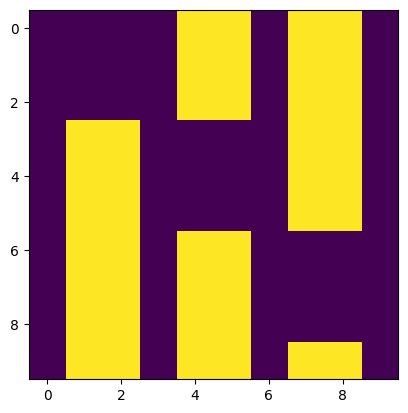

In [9]:
mk = generate_thoughtsformer_mask(0, 10, 2)
plt.imshow(mk)